In [1]:
import sys, os, time
import torch
sys.path.append("../src/")

import utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate

In [2]:
ceph_dir = utils.get_ceph_dir()
mike_data_dir = os.path.join(ceph_dir, "mike_data")

In [29]:
metadata = {"diffre": {"name": "2D Diffusion-Reaction",
                       "model": "MPP-AViT-B",
                       "path": "diffre2d",
                       "fields": ["$u$", "$v$"],
                        "fps": 5,
                       "dynamic_range": True},
            "incompNS": {"name": "Incompressible Navier-Stokes",
                         "model": "MPP-AViT-B",
                         "path": "incompNS",
                         "fields": ['$v_x$', '$v_y$', '$\\rho_\\mathrm{smoke}$'],
                         "fps": 10,
                         "dynamic_range": False},
            "swe": {"name": "2D Shallow-Water",
                    "model": "MPP-AViT-B",
                    "path": "swe",
                    "fields": ['$h$'],
                     "fps": 5,
                    "dynamic_range": False},
            "turb800": {"name": "Compressible Navier-Stokes (Turb)",
                        "model": "MPP-AViT-B (Finetuned 800)",
                        "path": "turb800",
                        "fields": ['$v_x$', '$v_y$', '$\\rho$', '$p$'],
                        "fps": 2,
                        "dynamic_range": True}}

In [30]:
dataname = "diffre"
out_filename = f"mpp_data_{dataname}.mp4"

cmap = "inferno"

save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none',
         'image.cmap': cmap}
plt.rcParams.update(params)

In [31]:
data_truth = np.swapaxes(np.load(os.path.join(mike_data_dir, metadata[dataname]["path"] + "_gt.npy"))[:, 0], 0, 1)

fields = metadata[dataname]["fields"]
dynamic_range = metadata[dataname]["dynamic_range"]
system_name = metadata[dataname]["name"]
model_name = metadata[dataname]["model"]
fps = metadata[dataname]["fps"]
total_fps = fps # To add interpolated frames, choose a total_fps > fps (choose multiples of fps)


In [32]:
print(data_truth.shape, data_pred.shape)

(2, 101, 128, 128) (4, 216, 512, 512)


In [33]:
def make_video(truth,
                  out_filename,
                  fields_labels=None,
                  fps=2,
                  total_fps=2,
                  dynamic_range=False,
                  system_name=None,
                  model_name=None):
    
    if fields_labels is None:
        fields_labels = fields

    nframes = truth.shape[-3]

    nSeconds = nframes // fps

    vmin = np.min(truth, axis=(-1, -2, -3))
    vmax = np.max(truth, axis=(-1, -2, -3))

    ims = []
    for i in range(1):
        ims.append([None,] * len(fields))

    i = 0
    
    fig, axs = plt.subplots(1, len(fields), figsize=(3*len(fields) if len(fields) > 1 else 3, 3), layout='constrained')
    if len(fields) == 1:
        axs = np.array([axs])
    axs = axs.reshape(1, len(fields))
    for j in range(len(fields)):
        ims[0][j] = axs[0, j].imshow(truth[j, i, :, :], vmin=vmin[j], vmax=vmax[j])
    for j in range(len(fields)):
        axs[0, j].set_title(fields_labels[j])
    # Remote tick labels
    for i in range(1):
        for j in range(len(fields)):
            if j != 0:
                # Remove y tick labels
                axs[i, j].set_yticklabels([])
    fig.subplots_adjust(wspace=0.15, hspace=0.15)

    def animate_func(i):
        if i % total_fps == 0:
            print( '.', end ='' )
        i_eff = i // (total_fps // fps)
        i_eff_mod = i % (total_fps // fps)
        if i_eff < nframes - 1:
            f_tru_interp = interpolate.interp1d([0, total_fps // fps], [truth[:, i_eff, :, :], truth[:, i_eff+1, :, :]], axis=0)
            truth_interp = f_tru_interp(i_eff_mod)
        elif i_eff == nframes - 1:
            truth_interp = truth[:, -1, :, :]
        else:
            truth_interp = np.empty_like(truth[:, -1, :, :])
            truth_interp[:] = np.nan
        for j in range(len(fields)):
            ims[0][j].set_array(truth_interp[j, :, :])

            if dynamic_range:
                vmin = np.percentile(truth_interp[j, :, :], 1)
                vmax = np.percentile(truth_interp[j, :, :], 99)
                ims[0][j].set_clim(vmin, vmax)

        return ims

    anim = animation.FuncAnimation(
                                fig,
                                animate_func, 
                                frames = nSeconds * total_fps,
                                interval = 1000 / total_fps, # in ms
                                )

    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=total_fps, bitrate=5000)

    anim.save(f'figs/{out_filename}', writer=writer) # Need to install ffmpeg and maybe

/tmp/ipykernel_1839012/2861606555.py:40: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.15, hspace=0.15)


......................

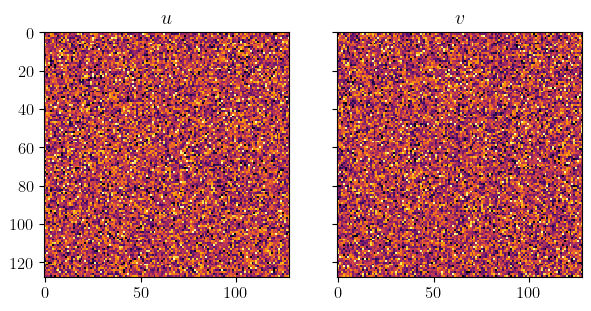

In [34]:
#make_video_v2(data_pred, out_filename)

make_video(data_truth,
              out_filename,
              fields_labels=fields,
              fps=fps,
              total_fps=total_fps,
              system_name=system_name,
              model_name=model_name,
              dynamic_range=dynamic_range)